In [420]:
library(tidyverse)
library(data.table)
library(repr)

In [240]:
repo_root <- normalizePath('../../')


In [321]:
dataset_list <- list(
    'clumped_snpnet' = c('test_20190324', 'HC_20190324', 'biomarkers_20190401'),
#     'vanilla'        = c('test_20190306', 'HC_20190302', 'biomarkers_20190401', 'cancer_20190302'),
    'vanilla'        = c('biomarkers_20190401'),    
    'snpnet'         = c('test_20190326', 'HC_20190303', 'biomarkers_20190331', 'cancer_20190303')
)

In [313]:
get_stats_filename <- function(dataset_name, method_name, repo_root){
    file <- file.path(
        repo_root, 
        'public_output', 
        paste0(method_name, '_PRS'), 
        paste0(dataset_name, '.tsv')
    )
    return(file)
}

In [314]:
read_datasets <- function(method_name, named_dataset_list, repo_root){
    named_dataset_list[method_name][[1]] %>%
    lapply(               
        function(x){
            dataset_n <- str_split(x, '_') %>% simplify() %>% first()
            dataset_v <- str_split(x, '_') %>% simplify() %>% last()            
            df <- tryCatch(                
                x %>%
                get_stats_filename(method_name, repo_root) %>%
                fread(data.table=FALSE) %>%
                mutate(
                    method = method_name,
                    dataset_name = dataset_n,
                    dataset_version = dataset_v,
                    dataset_full = x
                ),
                error=function(e){NULL}
            )
            if(!is.null(df)) {
                colnames(df) <- gsub("^#", "", colnames(df))
            }
            df
        }
    ) %>%
    bind_rows()
}

In [315]:
read_all_data <- function(dataset_named_list, repo_root){
    dataset_named_list %>% names() %>% lapply(
        function(x){
            read_datasets(x, dataset_named_list, repo_root)
        }
    ) %>% 
    bind_rows() %>%
    replace_na(list(N = 0))
    
}

In [409]:
R_or_AUC_plot <- function(df, title){
    df %>%
    ggplot(
        aes(x = PRS_model, y=R_or_AUC, fill = PRS_model)
    ) + 
    facet_grid(phe_name~features, space='free_x', scales = "free") +
    geom_bar(stat = 'identity') + 
    theme(
        axis.title.x=element_blank(),
    #     axis.text.x = element_text(angle = 30, hjust = 1),    
        axis.text.x=element_blank(),    
        axis.ticks.x=element_blank(),
        legend.position="bottom"
    ) + 
    labs(
        y = 'R or AUC',
        title = title,
        fill = 'Method'
    ) + 
    scale_fill_brewer(palette = "Set2") +
    guides(fill=guide_legend(nrow=2,byrow=TRUE))    
}

In [448]:
compute_clumped_snpnet_diff <- function(df){
    df %>% 
    select(-method, -dataset_full, -dataset_version) %>%
    arrange(phe_name, PRS_model) %>%
    spread(PRS_model, R_or_AUC) %>%
    mutate(
        clumped_snpnet_best = pmax(
            `clumped_snpnet_PRS_1e-3`,
            `clumped_snpnet_PRS_1e-4`,
            `clumped_snpnet_PRS_1e-5`,
            na.rm = TRUE
        )
    ) %>%
    mutate(
        clumped_snpnet_diff = clumped_snpnet_best - snpnet_PRS
    )     
}

In [323]:
df <- dataset_list %>% read_all_data(repo_root)

In [453]:
plot_width <- 5
plot_height <- 5
options(repr.plot.width=plot_width , repr.plot.height=plot_height)

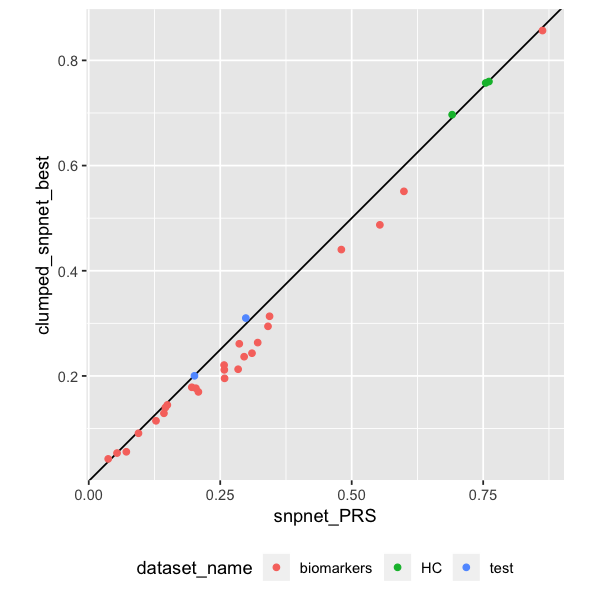

In [465]:
df %>% 
compute_clumped_snpnet_diff %>%
filter(
    features == 'Genotype_and_covariates'
) %>%
drop_na(snpnet_PRS, clumped_snpnet_best, dataset_name) %>%
ggplot(
    aes(x = snpnet_PRS, y=clumped_snpnet_best, color = dataset_name)
) +
geom_abline(intercept = 0, slope = 1) +
geom_point(stat = 'identity') + 
theme(
    legend.position="bottom"
) +
coord_fixed() 

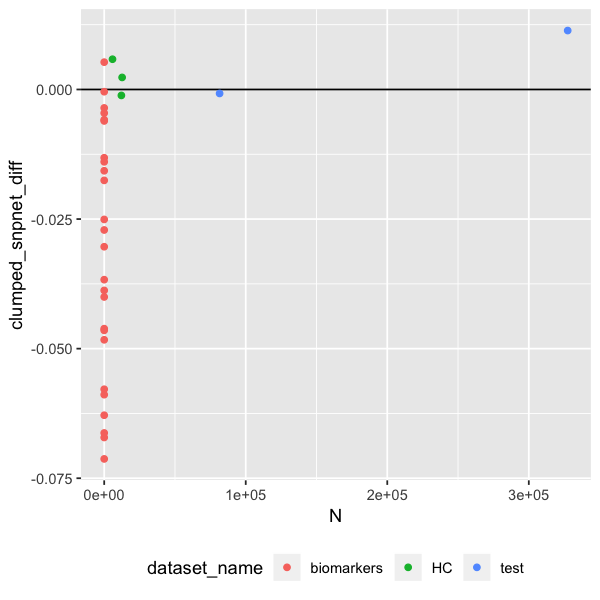

In [467]:
df %>% 
compute_clumped_snpnet_diff %>%
filter(
    features == 'Genotype_and_covariates'
) %>%
drop_na(clumped_snpnet_diff, N) %>%
ggplot(
    aes(x = N, y=clumped_snpnet_diff, color = dataset_name)
) +
geom_abline(intercept = 0, slope = 0) +
geom_point(stat = 'identity') + 
theme(
    legend.position="bottom"
)

In [469]:
df %>% 
arrange(-N) %>% head()

GBE_ID,PRS_model,phe_type,features,R_or_AUC,phe_name,N,method,dataset_name,dataset_version,dataset_full
INI50,clumped_snpnet_PRS_1e-3,qt,Covariates_only,0.7273773,Standing_height,336500,clumped_snpnet,test,20190324,test_20190324
INI50,clumped_snpnet_PRS_1e-3,qt,Genotype_and_covariates,0.8282831,Standing_height,336500,clumped_snpnet,test,20190324,test_20190324
INI50,clumped_snpnet_PRS_1e-3,qt,Genotype_only,0.3975276,Standing_height,336500,clumped_snpnet,test,20190324,test_20190324
INI50,clumped_snpnet_PRS_1e-4,qt,Covariates_only,0.7274144,Standing_height,336500,clumped_snpnet,test,20190324,test_20190324
INI50,clumped_snpnet_PRS_1e-4,qt,Genotype_and_covariates,0.8227486,Standing_height,336500,clumped_snpnet,test,20190324,test_20190324
INI50,clumped_snpnet_PRS_1e-4,qt,Genotype_only,0.3852755,Standing_height,336500,clumped_snpnet,test,20190324,test_20190324


In [398]:
df %>% filter(
    dataset_name == 'HC'
) %>% arrange(phe_name, PRS_model)

GBE_ID,PRS_model,phe_type,features,R_or_AUC,phe_name,N,method,dataset_name,dataset_version,dataset_full
HC382,snpnet_PRS,bin,Covariates_only,0.5303084,asthma,43626,snpnet,HC,20190303,HC_20190303
HC382,snpnet_PRS,bin,Genotype_and_covariates,0.6188714,asthma,43626,snpnet,HC,20190303,HC_20190303
HC382,snpnet_PRS,bin,Genotype_only,0.6160594,asthma,43626,snpnet,HC,20190303,HC_20190303
HC281,clumped_snpnet_PRS_1e-3,bin,Covariates_only,0.7294344,atrial_fibrillation,12665,clumped_snpnet,HC,20190324,HC_20190324
HC281,clumped_snpnet_PRS_1e-3,bin,Genotype_and_covariates,0.7072672,atrial_fibrillation,12665,clumped_snpnet,HC,20190324,HC_20190324
HC281,clumped_snpnet_PRS_1e-3,bin,Genotype_only,0.5709280,atrial_fibrillation,12665,clumped_snpnet,HC,20190324,HC_20190324
HC281,clumped_snpnet_PRS_1e-4,bin,Covariates_only,0.7296626,atrial_fibrillation,12665,clumped_snpnet,HC,20190324,HC_20190324
HC281,clumped_snpnet_PRS_1e-4,bin,Genotype_and_covariates,0.7477991,atrial_fibrillation,12665,clumped_snpnet,HC,20190324,HC_20190324
HC281,clumped_snpnet_PRS_1e-4,bin,Genotype_only,0.6065973,atrial_fibrillation,12665,clumped_snpnet,HC,20190324,HC_20190324
HC281,clumped_snpnet_PRS_1e-5,bin,Covariates_only,0.7296231,atrial_fibrillation,12665,clumped_snpnet,HC,20190324,HC_20190324


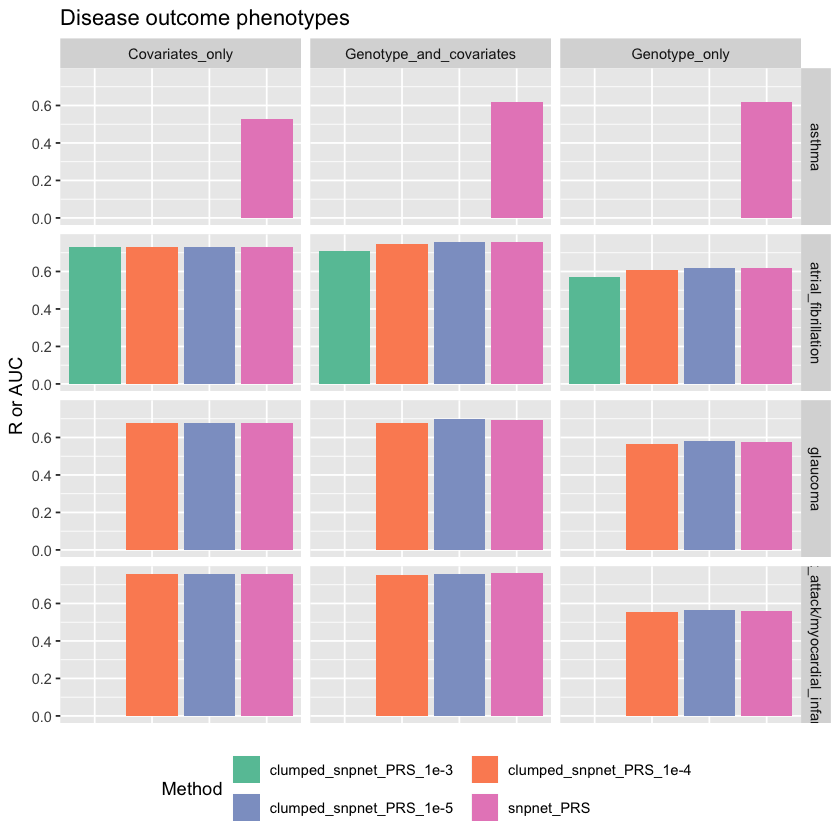

In [402]:
df %>% filter(
    dataset_name == 'HC'
) %>%
R_or_AUC_plot('Disease outcome phenotypes')

In [414]:
df %>% filter(
    dataset_name == 'test',
    features %in% c('Covariates_only', 'Genotype_and_covariates', 'Genotype_only'),
    GBE_ID != 'HC276'
) %>% arrange(phe_name, PRS_model)

GBE_ID,PRS_model,phe_type,features,R_or_AUC,phe_name,N,method,dataset_name,dataset_version,dataset_full
INI30150,clumped_snpnet_PRS_1e-3,qt,Covariates_only,0.08804011,Eosinophill_count,327479,clumped_snpnet,test,20190324,test_20190324
INI30150,clumped_snpnet_PRS_1e-3,qt,Genotype_and_covariates,0.30772250,Eosinophill_count,327479,clumped_snpnet,test,20190324,test_20190324
INI30150,clumped_snpnet_PRS_1e-3,qt,Genotype_only,0.29520680,Eosinophill_count,327479,clumped_snpnet,test,20190324,test_20190324
INI30150,clumped_snpnet_PRS_1e-4,qt,Covariates_only,0.08812764,Eosinophill_count,327479,clumped_snpnet,test,20190324,test_20190324
INI30150,clumped_snpnet_PRS_1e-4,qt,Genotype_and_covariates,0.31003030,Eosinophill_count,327479,clumped_snpnet,test,20190324,test_20190324
INI30150,clumped_snpnet_PRS_1e-4,qt,Genotype_only,0.29746400,Eosinophill_count,327479,clumped_snpnet,test,20190324,test_20190324
INI30150,clumped_snpnet_PRS_1e-5,qt,Covariates_only,0.08837006,Eosinophill_count,327479,clumped_snpnet,test,20190324,test_20190324
INI30150,clumped_snpnet_PRS_1e-5,qt,Genotype_and_covariates,0.30424940,Eosinophill_count,327479,clumped_snpnet,test,20190324,test_20190324
INI30150,clumped_snpnet_PRS_1e-5,qt,Genotype_only,0.29136160,Eosinophill_count,327479,clumped_snpnet,test,20190324,test_20190324
INI30150,snpnet_PRS,qt,Covariates_only,0.09188226,Eosinophill_count,327479,snpnet,test,20190326,test_20190326


In [423]:
plot_width <- 8
plot_height <- 8
options(repr.plot.width=plot_width , repr.plot.height=plot_height)

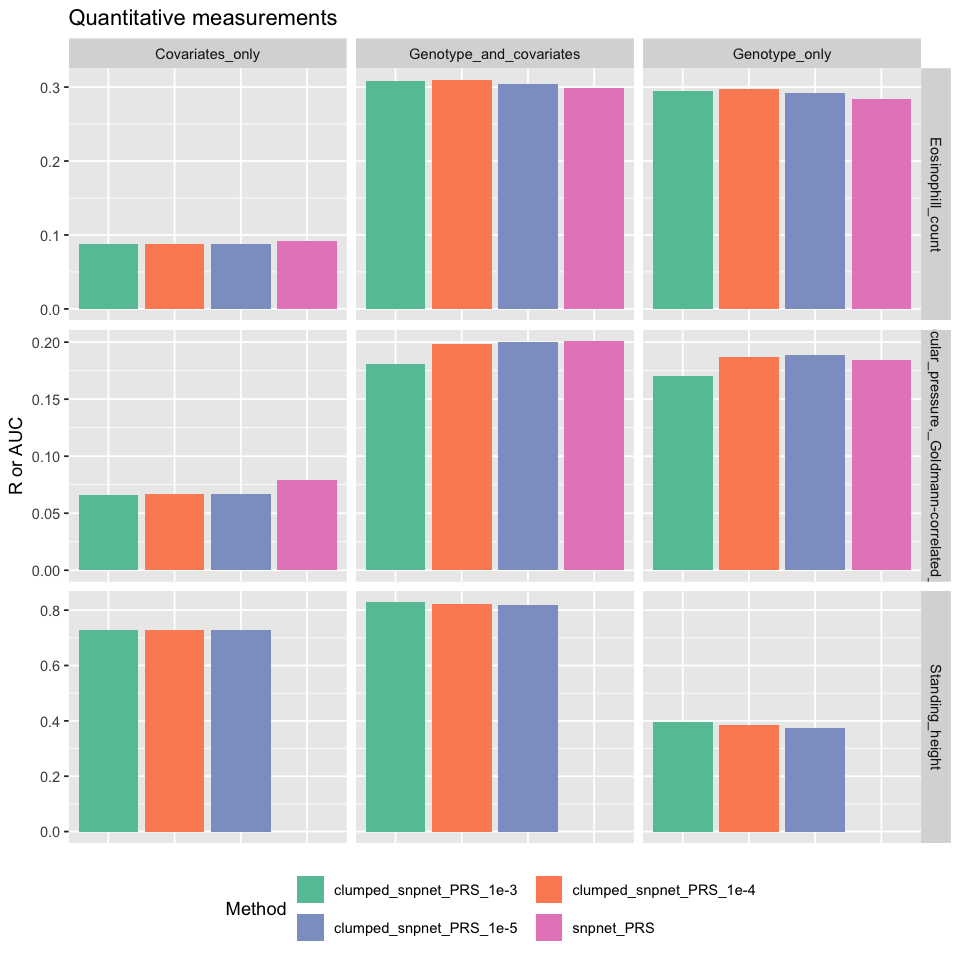

In [424]:
df %>% filter(
    dataset_name == 'test',
    features %in% c('Covariates_only', 'Genotype_and_covariates', 'Genotype_only'),
    GBE_ID != 'HC276'
) %>%
R_or_AUC_plot('Quantitative measurements')

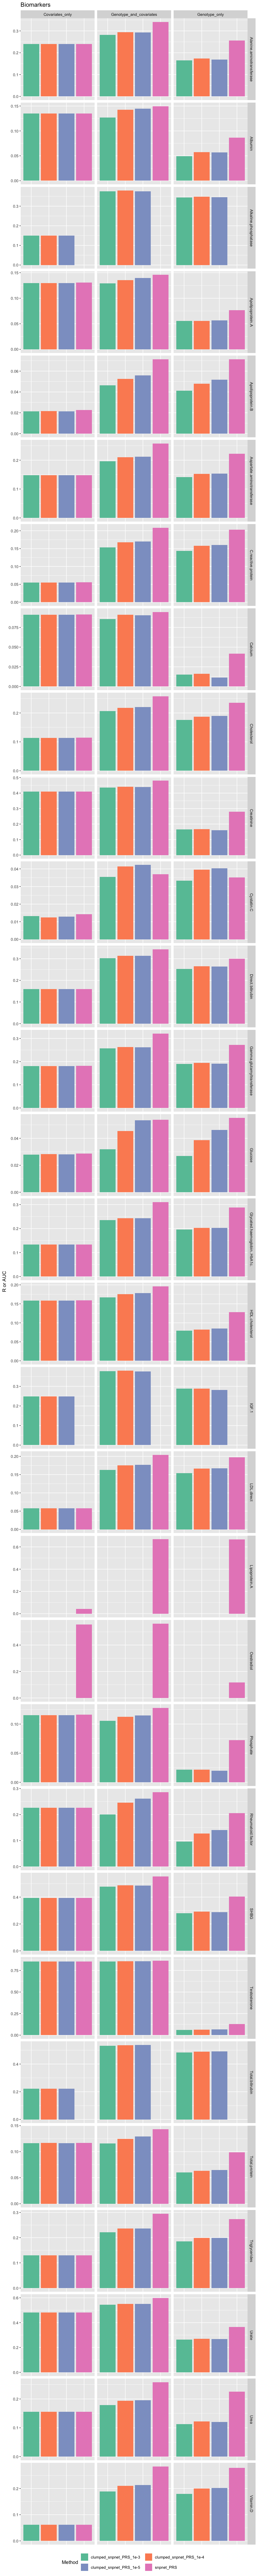

In [425]:
plot_width <- 8
plot_height <- 80
options(repr.plot.width=plot_width , repr.plot.height=plot_height)

df %>% filter(
    dataset_name == 'biomarkers'    
#     features %in% c('Covariates_only', 'Genotype_and_covariates', 'Genotype_only'),
#     GBE_ID != 'HC276'
) %>%
arrange(phe_name) %>%
R_or_AUC_plot('Biomarkers')

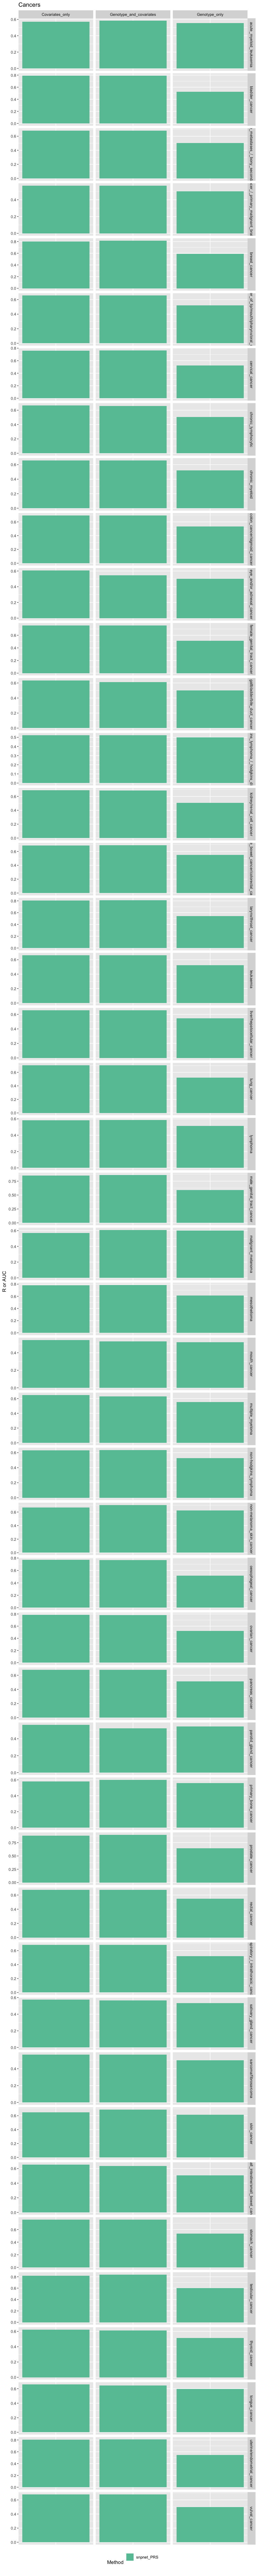

In [427]:
plot_width <- 8
plot_height <- 80
options(repr.plot.width=plot_width , repr.plot.height=plot_height)

df %>% filter(
    dataset_name == 'cancer'    
#     features %in% c('Covariates_only', 'Genotype_and_covariates', 'Genotype_only'),
#     GBE_ID != 'HC276'
) %>%
arrange(phe_name) %>%
R_or_AUC_plot('Cancers')